In [69]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import linear_model, neighbors, ensemble, naive_bayes, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE, SMOTENC

import plotly
plotly.tools.set_credentials_file(username='extralime', api_key='q3tUGZrv40fkKyR4uPuL')
import plotly.plotly as py
import plotly.graph_objs as go
import colorlover as cl

from IPython.display import Image
from IPython.display import HTML

import warnings

warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')

warnings.filterwarnings(
    module='sklearn',
    action='ignore',
    message='Data with')
warnings.filterwarnings(
    module='pandas',
    action='ignore',
    message='.ix')

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

class CustomScaler(BaseEstimator,TransformerMixin): 
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        self.scaler = StandardScaler(copy,with_mean,with_std)
        self.columns = columns

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.ix[:,~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]


#import the data, manage nulls and date field
df = pd.read_csv('lemon_train.csv')

df.PurchDate = pd.to_datetime(df.PurchDate)
df['pyear'] = df['PurchDate'].dt.year.astype(int)
df['pmonth'] = df['PurchDate'].dt.month.astype(int)
df['pday'] = df['PurchDate'].dt.day.astype(int)
#Drop the date and other columns
df.drop(['RefId', 'BYRNO', 'AUCGUART', 'PRIMEUNIT',
         'VNZIP1','WheelType', 'VehYear','PurchDate'],1,inplace=True)
df.dropna(inplace=True)
#add 1 to vehicle age (for math)
df.VehicleAge = [x+1 for x in df.VehicleAge]

#Separate and combine columns of interest
models = df.Model
submods = df.SubModel
trims = df.Trim
chars = df[['Model','SubModel','Trim']] 

#keyword list for model characteristics
mod_chars = ['2WD','V6','4C','PICKUP','6C','FWD',
             '4WD','AWD','SFI','EFI','DOHC','I4','MPI']

#keyowrd list for submodel characteristics
submod_chars = ['SEDAN','4D','EXT','CAB','2D','CAB','WAGON',
                'REG','FFV','PASSENGER','SUV','SPORT',
                'UTILITY','QUAD','COUPE','MINIVAN','CUV']

#Create a dataframe and extract keywords from model and submodel.
sub_val_sets, mod_val_sets = pd.DataFrame(),pd.DataFrame()

for key in submod_chars:
    subs = np.where(submods.str.contains(key),1,0) #create array for dummied char prescence    
    sub_val_sets[key] = subs #insert to dataframe
for key in mod_chars:
    mods = np.where(models.str.contains(key),1,0)
    mod_val_sets[key] = mods

#combine the two characteristic sets
char_dummies = pd.concat([mod_val_sets,sub_val_sets],axis=1)  

displacement = chars.SubModel.str.split('.').reset_index()
disp_ok = []
#Only keep entries with engine size len(Submodel) == 2
for model in displacement.SubModel:
    if len(model) == 2:
        disp_ok.append(model)
        
#Finally take the last element from 1st list, insert '.' add lasr element of 2nd list
displacements = []
for i in range(len(disp_ok)):
    beg = disp_ok[i][0][-1]
    end = disp_ok[i][1][0]
    whole = beg+'.'+end
    displacements.append(whole)
displacements = pd.Series(displacements)
ds_val_cnts = displacements.value_counts().reset_index()

#create dummie matrix for engine displacements
disp_keys = pd.DataFrame()
for key in ds_val_cnts['index']:
    dsps = np.where(df.SubModel.str.contains(key),1,0) #create array for dummied char prescence    
    disp_keys[key] = dsps #insert to dataframe
    
#combine the three new dataframes
mod_val_sets.reset_index(drop=True,inplace=True)
sub_val_sets.reset_index(drop=True,inplace=True)
disp_keys.reset_index(drop=True,inplace=True)



#subtract everything from everything
plodf= df[['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
 'VehicleAge','VehOdo','WarrantyCost','IsBadBuy']].copy()
plodf.dropna(inplace=True)
plodf['crcp_cacp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentAuctionCleanPrice
plodf['arcp_aacp'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRAcquisitionAuctionCleanPrice
plodf['crap_caap'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRCurrentAuctionAveragePrice
plodf['arap_aaap'] = plodf.MMRAcquisitionRetailAveragePrice - plodf.MMRAcquisitionAuctionAveragePrice

plodf['caap_aaap'] = plodf.MMRCurrentAuctionAveragePrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['cacp_aacp'] = plodf.MMRCurrentAuctionCleanPrice - plodf.MMRAcquisitionAuctionCleanPrice
plodf['crap_arap'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRAcquisitionRetailAveragePrice
plodf['crcp_arcp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRAcquisitonRetailCleanPrice

plodf['crcp_crap'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentRetailAveragePrice
plodf['arcp_arap'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRAcquisitionRetailAveragePrice
plodf['cacp_caap'] = plodf.MMRCurrentAuctionCleanPrice - plodf.MMRCurrentAuctionAveragePrice
plodf['aacp_aaap'] = plodf.MMRAcquisitionAuctionCleanPrice - plodf.MMRAcquisitionAuctionAveragePrice

plodf['crcp_caap'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentAuctionAveragePrice
plodf['arcp_aaap'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['crap_cacp'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRCurrentAuctionCleanPrice
plodf['arap_aacp'] = plodf.MMRAcquisitionRetailAveragePrice - plodf.MMRAcquisitionAuctionCleanPrice

plodf['crcp_arap'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRAcquisitionRetailAveragePrice
plodf['arcp_crap'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRCurrentRetailAveragePrice
plodf['cacp_aaap'] = plodf.MMRCurrentAuctionCleanPrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['aacp_caap'] = plodf.MMRAcquisitionAuctionCleanPrice - plodf.MMRCurrentAuctionAveragePrice

plodf['crcp_aacp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRAcquisitionAuctionCleanPrice
plodf['arcp_cacp'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRCurrentAuctionCleanPrice
plodf['crap_aaap'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['arap_caap'] = plodf.MMRAcquisitionRetailAveragePrice - plodf.MMRCurrentAuctionAveragePrice

plodf['crcp_crap_cacp_caap'] = plodf['crcp_crap']-plodf['cacp_caap']
plodf['arcp_arap_aacp_aaap'] = plodf['arcp_arap']-plodf['aacp_aaap']

plodf['crcp_cacp_arcp_aacp'] = plodf['crcp_cacp']-plodf['arcp_aacp']
plodf['crap_caap_arap_aaap'] = plodf['crap_caap']-plodf['arap_aaap']

plodf['crcp_caap_arcp_aaap'] = plodf['crcp_caap']-plodf['arcp_aaap']
plodf['crap_cacp_arap_aacp'] = plodf['crap_cacp']-plodf['arap_aacp']

plodf['crcp_arap_arcp_crap'] = plodf['crcp_arap']-plodf['arcp_crap']
plodf['cacp_aaap_aacp_caap'] = plodf['cacp_aaap']-plodf['aacp_caap']

plodf['crcp_aacp_arcp_cacp'] = plodf['crcp_caap']-plodf['arcp_aaap']
plodf['crap_aaap_arap_caap'] = plodf['crap_cacp']-plodf['arap_aacp']

plodf['crcp_cacp_war'] = plodf['crcp_cacp']* df.WarrantyCost/df.VehicleAge
plodf['crcp_cacp_logwar'] = plodf['crcp_cacp_war']
plodf['crcp_cacp_losqwar'] = plodf['crcp_cacp']* df.WarrantyCost/np.sqrt(df.VehicleAge)
plodf['crap_aaap_war'] = plodf['crap_aaap']* df.WarrantyCost/df.VehicleAge
plodf['log_war_age'] = df.WarrantyCost/df.VehicleAge
plodf['odo_age'] = np.log(df.VehOdo/df.VehicleAge)
plodf['odo_war'] = np.log((df.WarrantyCost/df.VehOdo))
plodf['another'] = np.log(df.WarrantyCost/df.VehOdo**2)
plodf['ugh'] = plodf.VehicleAge * (plodf.crcp_caap/plodf.WarrantyCost)
        
cont_df = plodf[['odo_age','log_war_age','crcp_cacp_war']]

#combine the three new dataframes
mod_val_sets.reset_index(drop=True,inplace=True)
sub_val_sets.reset_index(drop=True,inplace=True)
disp_keys.reset_index(drop=True,inplace=True)
cont_df.reset_index(drop=True,inplace=True)

add_feats = pd.concat([mod_val_sets,sub_val_sets,disp_keys,cont_df],axis=1)

#combine new features to our existing attributes
df.reset_index(drop=True,inplace=True)
model_df = pd.concat([df,add_feats],axis=1)
model_df.drop(['SubModel'],1,inplace=True)
model_df.Model = model_df.Model.str.split().str[0].str.strip()
model_df.Transmission = np.where(model_df.Transmission == 'AUTO',1,0)

scale_cols = ['VehicleAge','MMRAcquisitionAuctionAveragePrice', 'VehOdo',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice','WarrantyCost','odo_age', 'log_war_age', 'crcp_cacp_war']
scale = CustomScaler(columns=scale_cols)

model_df = scale.fit_transform(model_df)

colors = cl.to_rgb(cl.scales['10']['div']['BrBG'])
HTML(cl.to_html( cl.scales['10']['div']['BrBG'] ))

/root/.pyenv/versions/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:54: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/root/.pyenv/versions/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [128]:

X = model_df.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)
y = model_df.IsBadBuy

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=1667)
lrc = linear_model.LogisticRegression(penalty='l1',class_weight={0:1,1:3},
                                      solver='liblinear',C=10, max_iter=300)
lrc.fit(X_train,y_train)
y_pred = lrc.predict(X_test)
print('\n\t\tClassification Report: KNN k=5\n')
print(classification_report(y_test,y_pred))
print("ROC_AUC SCORE: {}".format(round(roc_auc_score(y_test,y_pred),2)))


		Classification Report: LRC (l1)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94     24305
           1       0.27      0.13      0.18      2605

   micro avg       0.88      0.88      0.88     26910
   macro avg       0.59      0.55      0.56     26910
weighted avg       0.85      0.88      0.86     26910

ROC_AUC SCORE: 0.55


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=1667)

In [67]:
lrc = linear_model.LogisticRegression(penalty='l1',class_weight={0:1,1:3},
                                      solver='liblinear',C=10, max_iter=300)
lrc.fit(X_train,y_train)
y_pred = lrc.predict(X_test)
print('\n\t\tClassification Report: LRC (l1)\n')
print(classification_report(y_test,y_pred))
print("ROC_AUC SCORE: {}".format(round(roc_auc_score(y_test,y_pred),2)))


LogisticRegression(C=10, class_weight={0: 1, 1: 3}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=300,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [80]:
y_pred = lrc.predict(X_test)
print('\n\t\tClassification Report: LRC (l1)\n')
print(classification_report(y_test,y_pred))
print("ROC_AUC SCORE: {}".format(round(roc_auc_score(y_test,y_pred),2)))


		Classification Report: LRC (l1)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94     24305
           1       0.27      0.13      0.18      2605

   micro avg       0.88      0.88      0.88     26910
   macro avg       0.59      0.55      0.56     26910
weighted avg       0.85      0.88      0.86     26910

ROC_AUC SCORE: 0.55


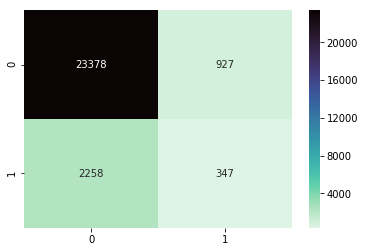

In [73]:
conmat = confusion_matrix(y_test,y_pred)
sns.heatmap(conmat,annot=True,fmt='d',cmap='mako_r',cbar=True)
plt.savefig('1st LLRC Scores',transparent=False)

In [115]:
rfc = ensemble.RandomForestClassifier(class_weight={0: 1, 1: 6}, criterion='gini', max_depth=7,
                                      max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300)
X = model_df.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)
y = model_df.IsBadBuy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=1667)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print('\n\t\tClassification Report: Logistic Regression (l1)\n')
print(classification_report(y_test,y_pred))
print("ROC_AUC SCORE: {}".format(round(roc_auc_score(y_test,y_pred),2)))


		Classification Report: Logistic Regression (l1)

              precision    recall  f1-score   support

           0       0.92      0.91      0.91     24305
           1       0.22      0.23      0.22      2605

   micro avg       0.85      0.85      0.85     26910
   macro avg       0.57      0.57      0.57     26910
weighted avg       0.85      0.85      0.85     26910

ROC_AUC SCORE: 0.57


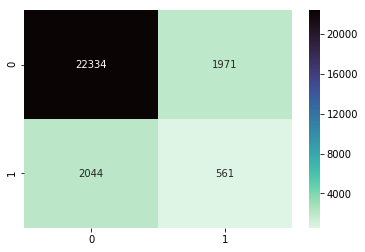

In [113]:
conmat = confusion_matrix(y_test,y_pred)
sns.heatmap(conmat,annot=True,fmt='d',cmap='mako_r',cbar=True)
plt.savefig('1st RFC Scores',transparent=False)

In [125]:
svc = svm.SVC(C=15,class_weight={0:1,1:6})

svc_df = model_df[:20000]

X = svc_df.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)
y = svc_df.IsBadBuy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=1667)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
print('\n\t\tClassification Report: SVC (rbf)\n')
print(classification_report(y_test,y_pred))
print("ROC_AUC SCORE: {}".format(round(roc_auc_score(y_test,y_pred),2)))

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.




		Classification Report: Logistic Regression (l1)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      7235
           1       0.13      0.11      0.12       765

   micro avg       0.85      0.85      0.85      8000
   macro avg       0.52      0.52      0.52      8000
weighted avg       0.83      0.85      0.84      8000

ROC_AUC SCORE: 0.52


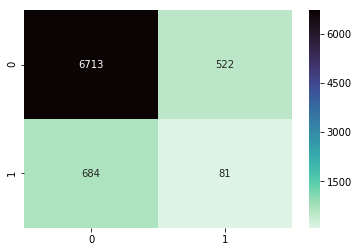

In [127]:
conmat = confusion_matrix(y_test,y_pred)
sns.heatmap(conmat,annot=True,fmt='d',cmap='mako_r',cbar=True)
plt.savefig('1st SVC Scores',transparent=False)

In [141]:
knn = neighbors.KNeighborsClassifier(n_neighbors=4,leaf_size=50,weights='distance')
X = model_df.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)
y = model_df.IsBadBuy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=1667)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))

[[23600   705]
 [ 2456   149]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     24305
           1       0.17      0.06      0.09      2605

   micro avg       0.88      0.88      0.88     26910
   macro avg       0.54      0.51      0.51     26910
weighted avg       0.83      0.88      0.85     26910

0.5140956597242102


In [144]:
print('\n\t\tClassification Report: KNN k=4\n')
print(classification_report(y_test,y_pred))
print("ROC_AUC SCORE: {}".format(round(roc_auc_score(y_test,y_pred),2)))


		Classification Report: KNN k=4

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     24305
           1       0.17      0.06      0.09      2605

   micro avg       0.88      0.88      0.88     26910
   macro avg       0.54      0.51      0.51     26910
weighted avg       0.83      0.88      0.85     26910

ROC_AUC SCORE: 0.51


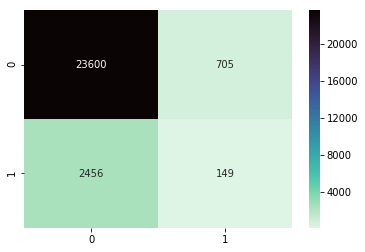

In [142]:
conmat = confusion_matrix(y_test,y_pred)
sns.heatmap(conmat,annot=True,fmt='d',cmap='mako_r',cbar=True)
plt.savefig('1st KNN Scores',transparent=False)

In [ ]:
X = test_mod.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)
#X = scaler.fit_transform(X)
y = test_mod.IsBadBuy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=167)
sm = SMOTE(random_state=163,sampling_strategy=.3)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
X_train = X_res
y_train = y_res

In [ ]:
X = model_df.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)

y = model_df.IsBadBuy

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=1167)

In [159]:
lrc = linear_model.LogisticRegression()
lrc.fit(X_train,y_train)

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
#run a loop test a number of different parameters on the same data
CS =[]
TN = []
FN = []
FP = []
TP = []
class_w = []
roc_auc = []
for i in [.2,.5,.8,2,5,10,15,20]:    
    for l in range(1,16):
        params = {'C': i,
              'penalty':'l1',
              'solver': 'liblinear',
              'class_weight':{0:1,1:l},
              'max_iter': 300  }
        # Initialize and fit the model.
        clf = linear_model.LogisticRegression(**params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # Accuracy tables.
        conf = confusion_matrix(y_test,y_pred)
        tns = conf[0][0]
        fps = conf[0][1]
        tps = conf[1][1]
        fns = conf[1][0]
        #append info
        TN.append(tns)
        FN.append(fns)
        FP.append(fps)
        TP.append(tps)
        class_w.append('1:{}'.format(l))
        roc_auc.append(roc_auc_score(y_test,y_pred))
        CS.append(i)

In [166]:
results = pd.DataFrame()
results['cs'] = CS
results['classw'] = class_w
results['TN'] = TN
results['FN'] = FN
results['FP'] = FP 
results['TP'] = TP
results['roc_auc'] = roc_auc


In [168]:
results.to_csv('lrcloop.csv')


		Classification Report: Logistic Regression (l1)

              precision    recall  f1-score   support

           0       0.94      0.62      0.75     24305
           1       0.15      0.63      0.25      2605

   micro avg       0.62      0.62      0.62     26910
   macro avg       0.55      0.63      0.50     26910
weighted avg       0.86      0.62      0.70     26910

ROC_AUC SCORE: 0.63


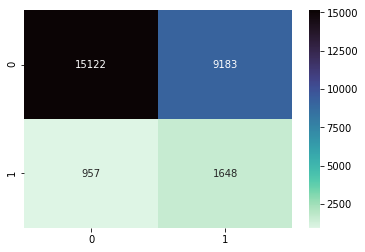

In [148]:
rfc = ensemble.RandomForestClassifier(class_weight={0: 1, 1: 10}, criterion='entropy', max_depth=5,
                                      max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5000)
X = model_df.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)
y = model_df.IsBadBuy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=1667)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print('\n\t\tClassification Report: Logistic Regression (l1)\n')
print(classification_report(y_test,y_pred))
print("ROC_AUC SCORE: {}".format(round(roc_auc_score(y_test,y_pred),2)))
conmat = confusion_matrix(y_test,y_pred)
sns.heatmap(conmat,annot=True,fmt='d',cmap='mako_r',cbar=True)
plt.show()

In [147]:
smote = pd.read_csv('correctrfcsmote.csv')

In [149]:
thing = classification_report(y_pred,y_test)

In [154]:
print(thing)

              precision    recall  f1-score   support

           0       0.62      0.94      0.75     16079
           1       0.63      0.15      0.25     10831

   micro avg       0.62      0.62      0.62     26910
   macro avg       0.63      0.55      0.50     26910
weighted avg       0.63      0.62      0.55     26910



In [157]:
(957+1648)/9183

0.28367635848851136

In [158]:
957/9183

0.10421430904933028